##Some preliminaries, you will need 
- package Match (Pkg.add("Match")) 
- PyCall
- a working Python, with scipy, numpy and qutip installed.

In [166]:
reload("PTSM.jl")
reload("Initial.jl")
reload("Symplectic.jl")

In [2]:
using PyCall

### Going to use python qutip to convert into superoperators

In [3]:
@pyimport scipy.optimize as so
@pyimport numpy as np
@pyimport matplotlib.pyplot as plt
@pyimport qutip as qt
@pyimport numpy.linalg as la

## We need to get the Python finite field package working

In [4]:
unshift!(PyVector(pyimport("sys")["path"]), "./finite-fields/")
@pyimport finitefield as ff

In [5]:
F22 = ff.FiniteField(2,2)

1 + 0 x^1 + 1 x^2
0 + 0 x^1 + 1 x^2
0 + 0 x^1 + 1 x^2
0 + 1 x^1 + 1 x^2
0 + 0 x^1 + 1 x^2
1 + 0 x^1 + 1 x^2
0 + 1 x^1 + 1 x^2
1 + 0 x^1 + 1 x^2
0 + 0 x^1 + 1 x^2
1 + 1 x^1 + 1 x^2


fn (generic function with 1 method)

In [7]:
@pyimport SLFunctions as sl


In [107]:
function getStabilisers()
    jstabs=Array{Int64,2}[]
    stabs = sl.getF2Stabilisers()
    for i in 1:60
        push!(jstabs,reshape(stabs[i,:,:],4,4))
    end
    return jstabs
end


getStabilisers (generic function with 1 method)

In [108]:
stabs=getStabilisers()

60-element Array{Array{Int64,2},1}:
 4x4 Array{Int64,2}:
 0  0  1  0
 0  0  0  1
 1  0  0  0
 0  1  0  0
 4x4 Array{Int64,2}:
 0  0  1  0
 0  0  0  1
 1  0  0  1
 0  1  1  1
 4x4 Array{Int64,2}:
 0  0  1  0
 0  0  0  1
 1  0  1  0
 0  1  0  1
 4x4 Array{Int64,2}:
 0  0  1  0
 0  0  0  1
 1  0  1  1
 0  1  1  0
 4x4 Array{Int64,2}:
 0  0  0  1
 0  0  1  1
 1  1  0  0
 1  0  0  0
 4x4 Array{Int64,2}:
 0  0  0  1
 0  0  1  1
 1  1  0  1
 1  0  1  1
 4x4 Array{Int64,2}:
 0  0  0  1
 0  0  1  1
 1  1  1  0
 1  0  0  1
 4x4 Array{Int64,2}:
 0  0  0  1
 0  0  1  1
 1  1  1  1
 1  0  1  0
 4x4 Array{Int64,2}:
 0  0  1  1
 0  0  1  0
 0  1  0  0
 1  1  0  0
 4x4 Array{Int64,2}:
 0  0  1  1
 0  0  1  0
 0  1  0  1
 1  1  1  1
 4x4 Array{Int64,2}:
 0  0  1  1
 0  0  1  0
 0  1  1  0
 1  1  0  1
 4x4 Array{Int64,2}:
 0  0  1  1
 0  0  1  0
 0  1  1  1
 1  1  1  0
 4x4 Array{Int64,2}:
 0  1  0  0
 1  1  0  0
 0  0  1  1
 0  0  1  0
 ⋮                                                                 

##So we have the F22 stabilisers (60 of them) loaded into stabs

In [111]:
stabs[25]

4x4 Array{Int64,2}:
 0  1  0  0
 1  1  0  0
 0  1  1  1
 1  1  1  0

###Lets try one, use setup to set up the stabiliser state, then decompose it.

In [112]:
state=setup(2)

4x5 Array{Int32,2}:
 1  0  0  0  0
 0  1  0  0  0
 0  0  1  0  0
 0  0  0  1  0

In [113]:
state[:,1:4]=stabs[25]

4x4 Array{Int64,2}:
 0  1  0  0
 1  1  0  0
 0  1  1  1
 1  1  1  0

In [114]:
state

4x5 Array{Int32,2}:
 0  1  0  0  0
 1  1  0  0  0
 0  1  1  1  0
 1  1  1  0  0

In [115]:
decomposeState(state)

Tableau for unitary: 
+IX
+XX
---
+ZY
+YX
setup(2)
phase(2)
phase(2)
phase(1)
phase(1)
phase(2)
phase(1)
hadamard(2)
hadamard(1)
phase(2)
phase(2)
phase(1)
phase(1)
phase(2)
phase(1)
cnot(1,2)
cnot(2,1)
output(svec)


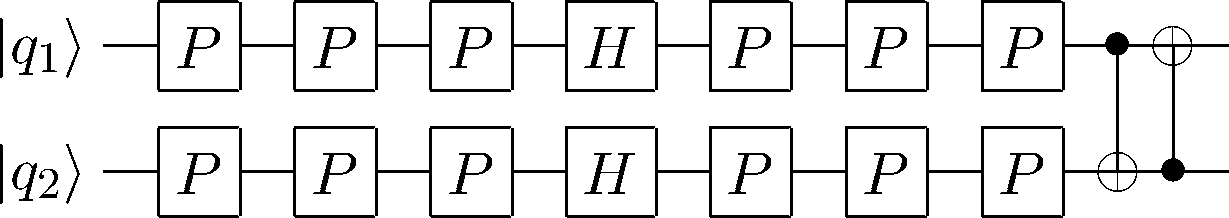

In [116]:
drawCircuit()

In [137]:
function makeFromCommand(command)
    currentState = [1 0 0 0;0 1 0 0;0 0 1 0;0 0 0 1]
    si = [1 0;0 1]
    sphase1=kron([1 0;0 im],si)
    sphase2=kron(si,[1 0;0 im])
    shadmard=1/sqrt(2)*[1 1;1 -1]
    shad1 = kron(shadmard,si)
    shad2 = kron(si,shadmard)
    cnot12 = [1 0 0 0;0 1 0 0;0 0 0 1;0 0 1 0]
    cnot21 = [1 0 0 0;0 0 0 1;0 0 1 0;0 1 0 0]
    for t in command
        m = match(r"setup\((.*)\)",t)
        if (m!=nothing)
           state=[1 0 0 0;0 1 0 0;0 0 1 0;0 0 0 1]
        else 
           m=match(r"phase\((.*)\)",t)
           if (m!=nothing)
                bit = int(m.captures[1])
                if bit == 1
                   currentState=currentState*sphase1
                else 
                   currentState=currentState*sphase2
                end
            else
                m=match(r"hadamard\((.*)\)",t)
                if (m!=nothing)
                    bit = int(m.captures[1])
                    if bit == 1
                        currentState=currentState*shad1
                    else 
                        currentState=currentState*shad2
                    end
                else
                    m=match(r"cnot\((.*),(.*)\)",t)
                    if (m!=nothing)
                        cbit = int(m.captures[1])
                        tbit = int(m.captures[2])
                        if cbit ==1 
                            currentState = currentState*cnot12
                        else
                            currentState = currentState*cnot21
                        end
                    end
                end
            end
        end
    end
    return  currentState=currentState
end


makeFromCommand (generic function with 1 method)

In [120]:
typeof(commands)

Array{ASCIIString,1}

###Looks good, so lets make them all

In [138]:
sl2Cliffords= Array{Complex{Float64},2}[]
sl2CliffordCommands = Array{ASCIIString,1}[]
for i=1:60
    state=setup(2)
    state[:,1:4]=stabs[i]
    decomposeState(state,true)
    push!(sl2CliffordCommands,commands)
    push!(sl2Cliffords,makeFromCommand(commands))
end
    
    
    


In [124]:
f[23]

10-element Array{ASCIIString,1}:
 "setup(2)"    
 "cnot(2,1)"   
 "phase(1)"    
 "cnot(2,1)"   
 "phase(2)"    
 "hadamard(2)" 
 "hadamard(1)" 
 "cnot(2,1)"   
 "cnot(1,2)"   
 "output(svec)"

In [139]:
sl2Cliffords[23]

4x4 Array{Complex{Float64},2}:
  0.5+0.0im  0.5+0.0im  0.5+0.0im   0.5+0.0im
 -0.5+0.0im  0.5+0.0im  0.5+0.0im  -0.5+0.0im
  0.0+0.5im  0.0-0.5im  0.0+0.5im   0.0-0.5im
  0.0+0.5im  0.0+0.5im  0.0-0.5im   0.0-0.5im

##Looking good again

### Time to use the Granade inspired/qutip superpauli

In [126]:
function to_superpauli(S):
    """
    Converts a superoperator in the column-stacking basis to the Pauli basis. Note that
    the argument is assumed to act on qubits.
    """
    sqobj=qt.to_super(S)
    nq=int(np.log2(sqobj[:shape][1])/2)
    B=pycall(qt.superop_reps["_pauli_basis"],PyAny,nq)
    sq=np.sqrt(2^nq)
    B=pyeval("B/sq",PyAny,B=B,nq=nq,sq=sq)
    B[:dims] = sqobj[:dims]
    sqobj = pycall(B[:dag]()["__mul__"],PyAny,pycall(sqobj["__mul__"],PyAny,B))
    return sqobj
end

to_superpauli (generic function with 1 method)

In [127]:
to_superpauli(qt.Qobj(sl2Cliffords[25]))

PyObject Quantum object: dims = [[[4], [4]], [[4], [4]]], shape = [16, 16], type = super, isherm = False, superrep = None
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0. 

###Not sure where I am going with that one.

##Let us just check if we do indeed have a unitary-2 design

- We should recall that these 60 cliffords implement Pauli twirling, that means we need to get the Paulis to twirl!


In [140]:
sigma=Array{Complex{Float64},2}[]
sigma2=Array{Complex{Float64},2}[]
# There is nothing clever about this, if we are to do for > 2 then
# we already have functions we should actually utilise.
push!(sigma,[1 0;0 1])
push!(sigma,[0 1;1 0])
push!(sigma,[0 -im;im 0])
push!(sigma,[1 0;0 -1])
for i in sigma
    for j in sigma
        push!(sigma2,kron(i,j))
    end
end
QE=Array{Complex{Float64},2}[]
for i=1:60
    for j=1:16
        push!(QE,sl2Cliffords[i]*sigma2[j])
    end
end
    

In [141]:
length(QE)

960

In [142]:
sum = 0
for i=1:960
    for j=1:960
        sum += abs(trace(conj(QE[i])'*QE[j]))^4
    end
end
print("$sum -> $(sum/(960^2))\n")

1.8431999999999998e6 -> 1.9999999999999998


#Yay!

In [145]:
for i in sl2CliffordCommands
    print(length(i),",")
end

4,10,10,10,6,12,12,14,6,12,12,12,4,14,10,14,18,16,16,12,22,18,10,18,18,8,14,18,2,8,8,8,16,14,14,6,20,20,14,18,18,12,18,18,4,12,14,14,16,16,16,10,18,14,8,20,18,10,18,20,

In [147]:
print(sl2CliffordCommands[60])

ASCIIString["setup(2)","cnot(2,1)","phase(1)","phase(1)","phase(2)","phase(1)","phase(2)","cnot(2,1)","phase(1)","hadamard(2)","hadamard(1)","cnot(2,1)","phase(1)","phase(1)","phase(1)","cnot(2,1)","phase(1)","cnot(1,2)","cnot(2,1)","output(svec)"]

In [148]:
commands = sl2CliffordCommands[60]

20-element Array{ASCIIString,1}:
 "setup(2)"    
 "cnot(2,1)"   
 "phase(1)"    
 "phase(1)"    
 "phase(2)"    
 "phase(1)"    
 "phase(2)"    
 "cnot(2,1)"   
 "phase(1)"    
 "hadamard(2)" 
 "hadamard(1)" 
 "cnot(2,1)"   
 "phase(1)"    
 "phase(1)"    
 "phase(1)"    
 "cnot(2,1)"   
 "phase(1)"    
 "cnot(1,2)"   
 "cnot(2,1)"   
 "output(svec)"

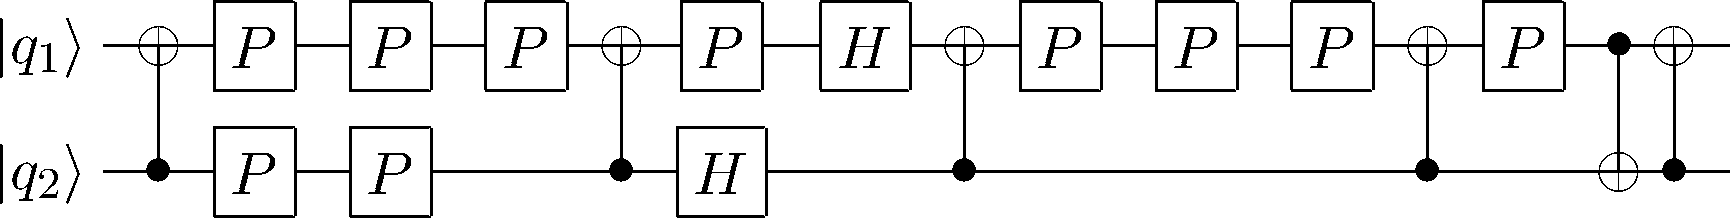

In [149]:
drawCircuit()

In [164]:
state=setup(2)
state[:,1:4]=stabs[60]
   

4x4 Array{Int64,2}:
 1  1  1  0
 1  0  0  1
 0  1  1  0
 1  1  0  1

In [163]:
decomposeState(state)

Tableau for unitary: 
+YX
+XZ
---
+ZX
+XY
setup(2)
cnot(2,1)
phase(1)
phase(1)
phase(2)
phase(1)
phase(2)
cnot(2,1)
phase(1)
hadamard(2)
hadamard(1)
cnot(2,1)
phase(1)
phase(1)
phase(1)
cnot(2,1)
phase(1)
cnot(1,2)
cnot(2,1)
output(svec)


In [167]:
bruteForceBreadthFirst(state)

Trying: 1 1 
Trying: 1 1 1 
Trying: 1 1 1 1 
Trying: 1 1 1 1 1 
Trying: 1 1 1 1 1 1 
Trying: 1 1 1 1 1 1 1 
Trying: 1 1 1 1 1 1 1 1 
Found it after (only) 738546 permuations
Gates applied
hadamard(svec,1,false)
phase(svec,1,false)
cnot(svec,2,1,false)
hadamard(svec,2,false)
cnot(svec,2,1,false)
phase(svec,2,false)
phase(svec,2,false)
phase(svec,2,false)


In [10]:
#Quick example
SO=to_superpauli(qt.Qobj(Clifford[2]))
test = real(SO[:full]())

4x4 Array{Float64,2}:
 1.0   0.0  0.0  0.0
 0.0   0.0  0.0  1.0
 0.0   0.0  1.0  0.0
 0.0  -1.0  0.0  0.0

In [11]:
# Make the PTSM.jl superoperators in a suitable form for equality testing
SuperClifford = Array{Float64}[]
for i=1:24
    push!(SuperClifford,round(generateClifford(i,0,0,0)))
end

In [43]:
#And generate the map
for j=1:24
    test = round(real(to_superpauli(qt.Qobj(Clifford[j]))[:full]()))
    for i=1:24
        if round(SuperClifford[i])== test
            print("$j=$i\n")
        end
    end
end

1=16
2=22
3=19
4=13
5=3
6=12
7=9
8=6
9=20
10=17
11=23
12=14
13=5
14=2
15=8
16=11
17=24
18=21
19=18
20=15
21=10
22=4
23=7
24=1


##Lets play a bit more and check what happens if we sum all of the qt superoperators.

In [13]:
So1 = to_superpauli(qt.Qobj(Clifford[2]))
So2 = to_superpauli(qt.Qobj(Clifford[2]))

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = False, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0. -1.  0.  0.]]

In [14]:
So1+So2

LoadError: `+` has no method matching +(::PyObject, ::PyObject)
while loading In[14], in expression starting on line 1

##Oops! (this is the way you do it)

In [15]:
pycall(So1["__add__"],PyAny,So2)

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = False, superrep = None
Qobj data =
[[ 2.  0.  0.  0.]
 [ 0.  0.  0.  2.]
 [ 0.  0.  2.  0.]
 [ 0. -2.  0.  0.]]

In [16]:
typeof(So1)

PyObject (constructor with 34 methods)

In [17]:
QtSuperOperators = PyObject[]
for i=1:24
    push!(QtSuperOperators,to_superpauli(qt.Qobj(Clifford[i])))
end


In [18]:
Start = QtSuperOperators[1]
for i=2:24
    Start = pycall(Start["__add__"],PyAny,QtSuperOperators[i])
end
Start

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = None
Qobj data =
[[ 24.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]]

## Yay!

##Let us find, all sequences of 6 cliffords that are a unitary-1 desgin, we can then check if any are a 2-design.

In [19]:
toMatch = int([6 0 0 0;0 0 0 0;0 0 0 0;0 0 0 0])
matched = Array{Int64,1}[]
for i1=1:19
    for i2=i1+1:20
        for i3=i2+1:21
            for i4=i3+1:22
                for i5=i4+1:23
                    for i6=i5+1:24
                        if   int(SuperClifford[i1]+
                                 SuperClifford[i2]+
                                 SuperClifford[i3]+
                                 SuperClifford[i4]+
                                 SuperClifford[i5]+
                            SuperClifford[i6]) == toMatch
                            print("Matched ===> $i1,$i2,$i3,$i4,$i5,$i6\n")
                            push!(matched,[i1,i2,i3,i4,i5,i6])
                        end
                    end
                end
            end
        end
    end
end


Matched ===> 1,2,3,19,20,21
Matched ===> 1,5,9,13,21,23
Matched ===> 1,6,11,18,19,23
Matched ===> 1,8,12,13,18,20
Matched ===> 2,4,12,16,20,24
Matched ===> 2,6,7,14,19,24
Matched ===> 2,9,10,14,16,21
Matched ===> 3,4,8,15,20,22
Matched ===> 3,5,10,17,21,22
Matched ===> 3,7,11,15,17,19
Matched ===> 4,5,6,22,23,24
Matched ===> 4,9,11,15,16,23
Matched ===> 5,7,12,13,17,24
Matched ===> 6,8,10,14,18,22
Matched ===> 7,8,9,13,14,15
Matched ===> 10,11,12,16,17,18


In [83]:
function addTwo(s1,s2)
    pycall(s1["__add__"],PyAny,s2)
end

addTwo (generic function with 1 method)

In [21]:
SuperClifford[1]

4x4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

In [23]:
QtSuperOperators[24]

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]

In [26]:
int(SuperClifford[6])

4x4 Array{Int64,2}:
 1  0   0   0
 0  0  -1   0
 0  0   0  -1
 0  1   0   0

In [25]:
QtSuperOperators[8]

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = False, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  1.  0.  0.]]

In [46]:
int(SuperClifford[11])

4x4 Array{Int64,2}:
 1   0   0  0
 0   0   0  1
 0  -1   0  0
 0   0  -1  0

In [48]:
QtSuperOperators[16]

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = False, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]]

In [34]:
int(SuperClifford[18])

4x4 Array{Int64,2}:
 1  0  0   0
 0  0  1   0
 0  1  0   0
 0  0  0  -1

In [35]:
QtSuperOperators[19]

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0. -1.]]

In [37]:
int(SuperClifford[19])

4x4 Array{Int64,2}:
 1   0   0   0
 0   0   0  -1
 0   0  -1   0
 0  -1   0   0

In [40]:
QtSuperOperators[3]

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]]

In [41]:
int(SuperClifford[23])

4x4 Array{Int64,2}:
 1   0  0  0
 0  -1  0  0
 0   0  0  1
 0   0  1  0

In [42]:
QtSuperOperators[11]

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]]

In [50]:
toMatch = int([6 0 0 0;0 0 0 0;0 0 0 0;0 0 0 0])
int(addTwo(QtSuperOperators[24],
         addTwo(QtSuperOperators[8],
         addTwo(QtSuperOperators[16],
         addTwo(QtSuperOperators[19],
addTwo(QtSuperOperators[3],QtSuperOperators[11])))))[:full]())==toMatch

true

In [51]:
#WARNING HORRIBLY SLOW

toMatch = int([6 0 0 0;0 0 0 0;0 0 0 0;0 0 0 0])
matchedQt = Array{Int64,1}[]
for i1=1:19
    for i2=i1+1:20
        for i3=i2+1:21
            for i4=i3+1:22
                for i5=i4+1:23
                    for i6=i5+1:24
                       if   int(addTwo(QtSuperOperators[i1],
                                addTwo(QtSuperOperators[i2],
                                addTwo(QtSuperOperators[i3],
                                addTwo(QtSuperOperators[i4],
                            addTwo(QtSuperOperators[i5],QtSuperOperators[i6])))))[:full]()) == toMatch
                            
                            print("Matched ===> $i1,$i2,$i3,$i4,$i5,$i6\n")
                            push!(matchedQt,[i1,i2,i3,i4,i5,i6])
                        end
                    end
                end
            end
        end
    end
end

Matched ===> 1,6,9,14,17,22
Matched ===> 1,6,10,16,19,21
Matched ===> 1,7,11,16,20,22
Matched ===> 1,7,12,14,18,21
Matched ===> 2,5,9,15,20,22
Matched ===> 2,5,10,13,18,21
Matched ===> 2,8,11,13,17,22
Matched ===> 2,8,12,15,19,21
Matched ===> 3,5,9,14,18,24
Matched ===> 3,5,10,16,20,23
Matched ===> 3,8,11,16,19,24
Matched ===> 3,8,12,14,17,23
Matched ===> 4,6,9,15,19,24
Matched ===> 4,6,10,13,17,23
Matched ===> 4,7,11,13,18,24
Matched ===> 4,7,12,15,20,23


In [379]:
int(addTwo(QtSuperOperators[1],
         addTwo(QtSuperOperators[6],
         addTwo(QtSuperOperators[7],
         addTwo(QtSuperOperators[18],
         addTwo(QtSuperOperators[19],QtSuperOperators[23])))))[:full]())

4x4 Array{Int64,2}:
 6   0  0   0
 0  -1  0  -1
 0   0  2   0
 0  -1  0  -3

In [371]:
int(addTwo(QtSuperOperators[1],addTwo(QtSuperOperators[2],QtSuperOperators[3]))[:full]())

4x4 Array{Int64,2}:
 3   0  0   0
 0   0  0  -1
 0   0  1   0
 0  -1  0   0

##Actually lets play with finite fields a bit

- I am not sure if it all works with one qubit, but lets see

## Just get the Python finite field package working
- I will generate the SL for GF($2^2$)
- Once thats done, I will go back and have a look at GF(2)

In [115]:
unshift!(PyVector(pyimport("sys")["path"]), "./finite-fields/")
@pyimport finitefield as ff


In [133]:
F22 = ff.FiniteField(2,2)

0 + 0 x^1 + 1 x^2
0 + 1 x^1 + 1 x^2
1 + 1 x^1 + 1 x^2


fn (generic function with 1 method)

In [175]:
count = 0 
eles = Array{Int64,1}[]
for i =1:2
    for j=1:2
        push!(eles,[i,j]) 
    end
end
fieldElements= PyObject[]
for i=1:4
    push!(fieldElements,F22(eles[i]))
end
reverse!(fieldElements)
SL2Members = Array{Int64,1}[]
for i =1:length(eles)
    for j=1:length(eles)
        for k=1:length(eles)
            for l=1:length(eles)
                if pycall(pycall(fieldElements[i]["__mul__"],PyAny,fieldElements[l])["__add__"],
                          PyAny,
                          pycall(fieldElements[j]["__mul__"],PyAny,fieldElements[k])) == F22([1])
                    push!(SL2Members,[i,j,k,l])
                end
            end
        end
    end
end


In [170]:
fieldElements

4-element Array{PyObject,1}:
 PyObject 0 \u2208 F_{2^2}        
 PyObject 0 + 1 x^1 \u2208 F_{2^2}
 PyObject 1 \u2208 F_{2^2}        
 PyObject 1 + 1 x^1 \u2208 F_{2^2}

In [176]:
length(SL2Members)

60

##So lets focus back on just the 1 bit version, this is really just 1 and 0
- Our finite field package doesn't work with just GF(2), but it should be easy enough to do manually!
- The dual basis eg $\hat a$ comes from multiplying by W, which here is just T(F21(1).F2(1)), = 1
- This is still going to map 1->1 and 0->0, which is self dual.
- So the SL Group, must be the following 6 arrays:
$\left(\array{1 0\\0 1}\right)$$\left(\array{1 1\\0 1}\right)$$\left(\array{1 0\\1 1}\right)$$\left(\array{0 1\\1 1}\right)$$\left(\array{1 1\\1 0}\right)$$\left(\array{0 1\\1 0}\right)$
(remembering -1 = 1)
- These represent the following six mappings:
   1. $\left(\array{1 0\\0 1}\right)$ X $\rightarrow$ X, Z $\rightarrow$ Z
   2. $\left(\array{1 1\\0 1}\right)$ X $\rightarrow$ X, Z $\rightarrow$ Y
   3. $\left(\array{1 0\\1 1}\right)$ X $\rightarrow$ Y, Z $\rightarrow$ Z
   4. $\left(\array{0 1\\1 1}\right)$ X $\rightarrow$ Z, Z $\rightarrow$ Y
   5. $\left(\array{1 1\\1 0}\right)$ X $\rightarrow$ Y, Z $\rightarrow$ X
   6. $\left(\array{0 1\\1 0}\right)$ X $\rightarrow$ Z, Z $\rightarrow$ X

In [72]:
function makeFromCommand(command)
    currentState = [1 0;0 1]
    sphase=[1 0;0 im]
    shadmard=1/sqrt(2)*[1 1;1 -1]
    for t in command
            m = match(r"setup\((.*)\)",t)
            if (m!=nothing)
                state=[1 0;0 1]
            else 
                m=match(r"phase\((.*)\)",t)
                if (m!=nothing)
                    currentState=currentState*sphase
                else
                    m=match(r"hadamard\((.*)\)",t)
                    if (m!=nothing)
                         currentState=currentState*shadmard
                    end
                end
            end
    end
    return  currentState=currentState
end



makeFromCommand (generic function with 1 method)

In [234]:
function matchIt(ss1)
    decomposeState(ss1,true)
    sp=to_superpauli(qt.Qobj(makeFromCommand(commands)))
    spd = round(real(sp[:full]()))
    for i=1:length(SuperClifford) #Note loops are fast in Julia
        if SuperClifford[i]==spd
            print("Matched $i\n")
            return i
        end
    end
end

matchIt (generic function with 1 method)

In [240]:
GFCliffords=[
    matchIt([1 0 0;0 1 0]), # X->X Z->Z
    matchIt([1 0 0;1 1 0]), # X->X Z->Y
    matchIt([1 1 0;0 1 0]), # X->Y Z->Z
    matchIt([0 1 0;1 1 0]), # X->Z Z->Y
    matchIt([1 1 0;1 0 0]), # X->Y Z->X
    matchIt([0 1 0;1 0 0])] # X->Z Z->X


Matched 1
Matched 14
Matched 15
Matched 11
Matched 6
Matched 13


6-element Array{Int64,1}:
  1
 14
 15
 11
  6
 13

In [242]:
sum=SuperClifford[GFCliffords[1]]
for i=2:length(GFCliffords)
    sum = sum + SuperClifford[GFCliffords[i]]
end
sum

4x4 Array{Float64,2}:
 6.0  0.0   0.0  0.0
 0.0  2.0  -2.0  2.0
 0.0  0.0   0.0  0.0
 0.0  2.0  -2.0  2.0

## So thats not correct 

However, it looks like I might need to actually multiply each of the Paulis by these things.

In [74]:
function matchQIt(ss1)
    decomposeState(ss1,true)
    sp=to_superpauli(qt.Qobj(makeFromCommand(commands)))
    for i=1:length(QtSuperOperators) #Note loops are fast in Julia
        if QtSuperOperators[i]==sp
            print("Matched $i\n")
            return i
        end
    end
end

matchQIt (generic function with 1 method)

In [77]:
GLQCliffords =[matchQIt([1 0 0;0 1 0]), # X->X Z->Z
       matchQIt([1 0 0;1 1 0]), # X->X Z->Y
    matchQIt([1 1 0;0 1 0]), # X->Y Z->Z
    matchQIt([0 1 0;1 1 0]), # X->Z Z->Y
    matchQIt([1 1 0;1 0 0]), # X->Y Z->X
    matchQIt([0 1 0;1 0 0])] # X->Z Z->X


Matched 24
Matched 12
Matched 20
Matched 16
Matched 8
Matched 4


6-element Array{Int64,1}:
 24
 12
 20
 16
  8
  4

##So what I have here are the GL cliffords identified from our stabilised cliffords
- Cliffords[X] gives you the actual Clifford i.e. 2x2
- QtSuperopertors[X] gives you the same clifford but in a Python Qt.Superoperator object.



###We should check that the superoperators sum to the same thing.

In [86]:
testy = QtSuperOperators[GLQCliffords[1]]
for i=2:6
    testy=addTwo(testy,QtSuperOperators[GLQCliffords[i]])
end
testy

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = False, superrep = None
Qobj data =
[[ 6.  0.  0.  0.]
 [ 0.  2. -2.  2.]
 [ 0.  0.  0.  0.]
 [ 0.  2. -2.  2.]]

##So thats the same, i.e. we have a correct mapping in GLQCliffords.

- Now I am going to take these six cliffords and create 24 Unitaries $U_iP_j$, where $i$ ranges 1..6 and $j$ 1..4 

In [104]:
sigma=Array{Complex{Float64},2}[]
push!(sigma,[1 0;0 1])
push!(sigma,[0 1;1 0])
push!(sigma,[0 -im;im 0])
push!(sigma,[1 0;0 -1])
QE=Array{Complex{Float64},2}[]
for i=1:6
    for j=1:4
        push!(QE,Clifford[GLQCliffords[i]]*sigma[j])
    end
end
    

In [105]:
length(QE)

24

In [106]:
sum = 0
for i=1:24
    for j=1:24
        sum += abs(trace(conj(QE[i])'*QE[j]))^4
    end
end
print("$sum -> $(sum/(24^2))\n")

1152.0 -> 2.0


#PERFECT ITS A UNITARY 2 DESIGN

## So it actually took a bit of trial and error to get the above result, whilst I was trying to work out what went wrong (I had forgotten to multiply by the Paulis), I investigated the six cliffords we were given and noticed that they weren't even a unitary-one design but apart from some "signs" they were - this lead to a body of investigation below, which isn't required but is interesting to keep.

Inspection from stuff done above (where we found all possible 6 candidate lists) shows us that there are two similar groups that do work, looking at the one 1,6,11,18,19,23 - we can see from inspection that  we can map 
- 13$\rightarrow$19, 
- 14$\rightarrow$23 and 
- 15$\rightarrow$18 

by changing the sign, in each case, in the second and third row.

In [261]:
SuperClifford[15]
   

4x4 Array{Float64,2}:
 1.0  0.0   0.0   0.0
 0.0  0.0  -1.0  -0.0
 0.0  1.0   0.0  -0.0
 0.0  0.0  -0.0   1.0

In [257]:
SuperClifford[18]

4x4 Array{Float64,2}:
 1.0   0.0   0.0   0.0
 0.0   0.0   1.0   0.0
 0.0   1.0  -0.0  -0.0
 0.0  -0.0   0.0  -1.0

In [258]:
SuperClifford[19]

4x4 Array{Float64,2}:
 1.0   0.0   0.0   0.0
 0.0   0.0   0.0  -1.0
 0.0  -0.0  -1.0  -0.0
 0.0  -1.0   0.0  -0.0

In [256]:
SuperClifford[23]

4x4 Array{Float64,2}:
 1.0   0.0   0.0   0.0
 0.0  -1.0  -0.0   0.0
 0.0   0.0   0.0   1.0
 0.0  -0.0   1.0  -0.0

## So a question is what stabilised states produce these cliffords.

Earlier we did a mapping from symplecic basis to the PTSM super operators we are using here, in particular 
- 19 = (5,3) maps to 18
- 3 (1,3) maps to 19
- 11 (3, 3) maps to 23

In [265]:
decompose(5,3,1)

Tableau for unitary: 
-Y
--
-Z
setup(1)
phase(1)
phase(1)
phase(1)
hadamard(1)
phase(1)
phase(1)
hadamard(1)
output(svec)


In [267]:
to_superpauli(qt.Qobj(makeFromCommand(commands)))

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0. -1.]]

In [268]:
SuperClifford[18]

4x4 Array{Float64,2}:
 1.0   0.0   0.0   0.0
 0.0   0.0   1.0   0.0
 0.0   1.0  -0.0  -0.0
 0.0  -0.0   0.0  -1.0

## So the plot thickens, 15 (formed from YZ) should maybe be 18, which is formed from -Y-Z

In [270]:
decompose(1,3,1)

Tableau for unitary: 
-Z
--
-X
setup(1)
phase(1)
phase(1)
hadamard(1)
phase(1)
phase(1)
output(svec)


In [271]:
to_superpauli(qt.Qobj(makeFromCommand(commands)))

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]]

In [272]:
SuperClifford[19]

4x4 Array{Float64,2}:
 1.0   0.0   0.0   0.0
 0.0   0.0   0.0  -1.0
 0.0  -0.0  -1.0  -0.0
 0.0  -1.0   0.0  -0.0

##And 13 ZX maps to 19 -Z-X

In [273]:
decompose(3,3,1)

Tableau for unitary: 
-X
--
-Y
setup(1)
phase(1)
phase(1)
phase(1)
hadamard(1)
phase(1)
output(svec)


In [274]:
to_superpauli(qt.Qobj(makeFromCommand(commands)))

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]]

In [275]:
SuperClifford[23]

4x4 Array{Float64,2}:
 1.0   0.0   0.0   0.0
 0.0  -1.0  -0.0   0.0
 0.0   0.0   0.0   1.0
 0.0  -0.0   1.0  -0.0

##And the last one, 14 which goes to 23, was stabilized by XY and maybe should have been stabilised by -X-Y

###I didn't do an XZ mapping let see $\left(\array{1 ,1\\0, 1}\right)\left(\array{1 \\1}\right)=\left(\array{0\\ 1}\right)$

In [278]:
SuperClifford[14]

4x4 Array{Float64,2}:
 1.0  0.0   0.0  0.0
 0.0  1.0   0.0  0.0
 0.0  0.0   0.0  1.0
 0.0  0.0  -1.0  0.0

In [281]:
to_superpauli(qt.Qobj(Clifford[12]))

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = False, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0. -1.  0.]]

In [309]:
cl12 = qt.Qobj(Clifford[12])
clDag12= qt.Qobj(Clifford[12])[:dag]()
sxz=pycall(qt.sigmax()["__mul__"],PyAny,qt.sigmaz())

PyObject Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0. -1.]
 [ 1.  0.]]

In [310]:
(pycall(cl12["__mul__"],PyAny,pycall(qt.sigmax()["__mul__"],PyAny,clDag12)))


PyObject Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.  1.]
 [ 1.  0.]]

In [311]:
pycall(cl12["__mul__"],PyAny,pycall(qt.sigmaz()["__mul__"],PyAny,clDag12))

PyObject Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.+0.j  0.+1.j]
 [ 0.-1.j  0.+0.j]]

In [312]:
(pycall(cl12["__mul__"],PyAny,pycall(sxz["__mul__"],PyAny,clDag12)))

PyObject Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.-1.j  0.+0.j]
 [ 0.+0.j  0.+1.j]]

##And checking out the other one

In [290]:
to_superpauli(qt.Qobj(Clifford[11]))

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]]

In [291]:
SuperClifford[23]

4x4 Array{Float64,2}:
 1.0   0.0   0.0   0.0
 0.0  -1.0  -0.0   0.0
 0.0   0.0   0.0   1.0
 0.0  -0.0   1.0  -0.0

In [318]:
cl11 = qt.Qobj(Clifford[11])
clDag11= qt.Qobj(Clifford[11])[:dag]()
(pycall(cl11["__mul__"],PyAny,pycall(qt.sigmax()["__mul__"],PyAny,clDag11)))

PyObject Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0. -1.]
 [-1.  0.]]

In [319]:
pycall(cl11["__mul__"],PyAny,pycall(qt.sigmaz()["__mul__"],PyAny,clDag11))

PyObject Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.+0.j  0.+1.j]
 [ 0.-1.j  0.+0.j]]

In [320]:
(pycall(cl11["__mul__"],PyAny,pycall(sxz["__mul__"],PyAny,clDag11)))

PyObject Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.+1.j  0.+0.j]
 [ 0.+0.j  0.-1.j]]

In [307]:
Clifford[12]

2x2 Array{Complex{Float64},2}:
 0.707107+0.0im            0.0-0.707107im
      0.0-0.707107im  0.707107+0.0im     

In [308]:
Clifford[11]

2x2 Array{Complex{Float64},2}:
 0.707107+0.0im             0.0+0.707107im
      0.0-0.707107im  -0.707107+0.0im     

##Not really helping me, the one we found 14 does the correct maps, the one we want (23) changes the sign for X and Y

###So, for a unitary two design, Gross tells us $\sum_\limits{U_k,U_k'} |tr(U_k^\dagger U_{k'})|^4/K^2$ should =2, lets check for the cliffords

In [357]:
sum = 0
for i=1:24
    for j=1:24
        sum += abs(trace(conj(Clifford[i])'*Clifford[j]))^4
    end
end
print("$sum -> $(sum/(24^2))\n")

1151.9999999999998 -> 1.9999999999999996


###Well its certainly true for the cliffords

###So lets check if its true for any of the "6 clifford unitary-1's" I found earlier

In [102]:
for iter=1:length(matchedQt)
    sum = 0
    elements=matchedQt[iter]
    print(elements)
    QE=Array{Complex{Float64},2}[]
    for i=1:6
        for j=1:4
            push!(QE,Clifford[elements[i]]*sigma[j])
        end
    end
for i=1:24
    for j=1:24
            sum+=abs((trace(conj(QE[i])'*QE[j])))^4
    end
end
    print("$iter = $(sum/(24^2))\n")
end

[1,6,9,14,17,22]1 = 1.9999999999999996
[1,6,10,16,19,21]2 = 1.9999999999999996
[1,7,11,16,20,22]3 = 1.9999999999999996
[1,7,12,14,18,21]4 = 1.9999999999999996
[2,5,9,15,20,22]5 = 1.9999999999999996
[2,5,10,13,18,21]6 = 1.9999999999999996
[2,8,11,13,17,22]7 = 1.9999999999999996
[2,8,12,15,19,21]8 = 1.9999999999999996
[3,5,9,14,18,24]9 = 1.9999999999999996
[3,5,10,16,20,23]10 = 1.9999999999999996
[3,8,11,16,19,24]11 = 1.9999999999999996
[3,8,12,14,17,23]12 = 1.9999999999999996
[4,6,9,15,19,24]13 = 1.9999999999999996
[4,6,10,13,17,23]14 = 1.9999999999999996
[4,7,11,13,18,24]15 = 1.9999999999999996
[4,7,12,15,20,23]16 = 1.9999999999999996


###And there we have it, each of them is a Unitary -2 design when conjugated with the Paulis. So it appears that any six-clifford unitary-1 design conjugated with each Pauli is a Unitary-2 design. Is this obvious?

###And also interesting they are "close" to a unitary-2 on their own (whatever that means)

In [103]:
for iter=1:length(matchedQt)
    sum = 0
    elements=matchedQt[iter]
    print(elements)
for i=1:6
    for j=1:6
            sum+=abs((trace(conj(Clifford[elements[i]])'*Clifford[elements[j]])))^4
    end
end
    print("$iter = $(sum/36)\n")
end


[1,6,9,14,17,22]1 = 2.1111111111111094
[1,6,10,16,19,21]2 = 2.1111111111111094
[1,7,11,16,20,22]3 = 2.1111111111111094
[1,7,12,14,18,21]4 = 2.1111111111111094
[2,5,9,15,20,22]5 = 2.1111111111111094
[2,5,10,13,18,21]6 = 2.1111111111111094
[2,8,11,13,17,22]7 = 2.1111111111111094
[2,8,12,15,19,21]8 = 2.1111111111111094
[3,5,9,14,18,24]9 = 2.1111111111111094
[3,5,10,16,20,23]10 = 2.1111111111111094
[3,8,11,16,19,24]11 = 2.1111111111111094
[3,8,12,14,17,23]12 = 2.1111111111111094
[4,6,9,15,19,24]13 = 2.1111111111111094
[4,6,10,13,17,23]14 = 2.1111111111111094
[4,7,11,13,18,24]15 = 2.1111111111111094
[4,7,12,15,20,23]16 = 2.1111111111111094


##So we have 24 Unitaries that are the 2-design from the GL Field, are they just cliffords (probably here)

In [140]:
##We are checking on the superpauli basis as its better for equality
for i=1:24
    for j=1:24
        test=int(to_superpauli(qt.Qobj(QE[i]))[:full]())
        if test==int(QtSuperOperators[j][:full]())
            print("$i matches $j\n")
        end
    end
end

1 matches 24
2 matches 22
3 matches 23
4 matches 21
5 matches 12
6 matches 10
7 matches 9
8 matches 11
9 matches 20
10 matches 19
11 matches 18
12 matches 17
13 matches 16
14 matches 15
15 matches 13
16 matches 14
17 matches 8
18 matches 5
19 matches 6
20 matches 7
21 matches 4
22 matches 1
23 matches 3
24 matches 2


In [141]:
#Just a quick check
print(QE[6],"\n")
Clifford[10]

Complex{Float64}[0.0 - 0.7071067811865475im 0.7071067811865475 + 0.0im
                 0.7071067811865475 + 0.0im 0.0 - 0.7071067811865475im]


2x2 Array{Complex{Float64},2}:
 0.707107+0.0im            0.0+0.707107im
      0.0+0.707107im  0.707107+0.0im     

In [142]:
to_superpauli(qt.Qobj(QE[6]))

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = False, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0.  1.  0.]]

In [144]:
QtSuperOperators[10]

PyObject Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = False, superrep = None
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0.  1.  0.]]

In [145]:
im*QE[6]

2x2 Array{Complex{Float64},2}:
 0.707107+0.0im            0.0+0.707107im
      0.0+0.707107im  0.707107+0.0im     

##So the same, other than a phase